<a href="https://colab.research.google.com/github/Maram-Elsayed/Airbnb-New-User-Bookings-Kaggle/blob/master/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

In [4]:
# Read Preprocessed data
train= pd.read_csv('drive/My Drive/airbnb/train_scaled_2.csv')
test= pd.read_csv('drive/My Drive/airbnb/test_scaled_2.csv')
train_labels = train['country_destination']
train = train.drop(['country_destination','id'], axis=1)
test_id=test['id']
test = test.drop('id', axis=1)

# Set traget label to numeric
le_label = LabelEncoder()
labels=le_label.fit_transform(train_labels)
train_labels=pd.DataFrame({'Column1': train_labels, 'country_destination': labels})
train_labels=train_labels.drop('Column1',axis=1)
train_labels.head()



,country_destination
0,7
1,7
2,10
3,11
4,10


**Creating the NDCG Scorer**

In [0]:
def folds_to_split(data,targets,train,test):
    data_tr = pd.DataFrame(data).iloc[train]
    data_te = pd.DataFrame(data).iloc[test]
    labels_tr = pd.DataFrame(targets).iloc[train]
    labels_te = pd.DataFrame(targets).iloc[test]
    return [data_tr, data_te, labels_tr, labels_te]

# Reference Kaggle
def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

#def ndcg_score(ground_truth, predictions, k=5):
def ndcg_score(te_labels, predict, k):
    lb = LabelBinarizer()
    lb.fit(range(len(predict) + 1))
    T = lb.transform(te_labels)
    scores = []
    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predict):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)  
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)
    
# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)


In [0]:
corr = train_users.corr()

# display the correlation matrix
display(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')


In [6]:
data_after = train.drop(['created_year','created_month','created_day','signup_flow','timestamp_first_active'], axis = 1)
test=test.drop(['created_year','created_month','created_day','signup_flow','timestamp_first_active'], axis = 1)
X1 = sm.tools.add_constant(train)
X2 = sm.tools.add_constant(data_after)

# create the series for both
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)
series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index=X2.columns)

print('DATA BEFORE')
print('-'*100)
display(series_before)

print('DATA AFTER')
print('-'*100)
display(series_after)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                          1.000000
timestamp_first_active       736.143618
gender                         1.085972
age                            1.029490
signup_flow                    1.336651
language_n                     1.005602
affiliate_channel_n            1.350732
signup_method_n                1.062893
affiliate_provider_n           1.216951
first_device_type_n            1.271382
first_browser_n                1.209313
signup_app_n                   1.134438
first_affiliate_tracked_n      1.121869
session_count                  1.170596
created_year                 758.507341
created_month                  2.166332
created_day                    1.002294
dtype: float64

DATA AFTER
----------------------------------------------------------------------------------------------------


const                        1.000000
gender                       1.045054
age                          1.021907
language_n                   1.004694
affiliate_channel_n          1.276609
signup_method_n              1.049929
affiliate_provider_n         1.208525
first_device_type_n          1.223502
first_browser_n              1.142382
signup_app_n                 1.126645
first_affiliate_tracked_n    1.104259
session_count                1.027589
dtype: float64

**Varying the quality of split**

In [7]:
from sklearn.model_selection import KFold
foldnum=0
kf = KFold(n_splits=10)
results = pd.DataFrame()
KFold(n_splits=10, shuffle=True,random_state=20160217)
for train, test in kf.split(train):
    foldnum+=1
    [tr_data, te_data, tr_labels, te_labels] = folds_to_split(data_after, labels, train, test)
    for criterion in ['entropy', 'gini']:
        dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion=criterion)
        dtree = dtree.fit(tr_data, tr_labels.values.ravel())
        dtree_predict = dtree.predict_proba(te_data) 
        score = ndcg_score(te_labels.values, dtree_predict, k=5)
        print ('Fold : {}, Criterion : {}, Score : {}'.format(foldnum, criterion, score ))
        results.loc[foldnum, 'criterion=%s'%criterion ] = score

Fold : 1, Criterion : entropy, Score : 0.6951130835266826
Fold : 1, Criterion : gini, Score : 0.6922458247147146
Fold : 2, Criterion : entropy, Score : 0.7486480843029449
Fold : 2, Criterion : gini, Score : 0.7483283132808549
Fold : 3, Criterion : entropy, Score : 0.7735223232058048
Fold : 3, Criterion : gini, Score : 0.7740194225028512
Fold : 4, Criterion : entropy, Score : 0.7683235560131534
Fold : 4, Criterion : gini, Score : 0.7679004713055644
Fold : 5, Criterion : entropy, Score : 0.7876257508545644
Fold : 5, Criterion : gini, Score : 0.78515829613003
Fold : 6, Criterion : entropy, Score : 0.8085473347867708
Fold : 6, Criterion : gini, Score : 0.8065522773193368
Fold : 7, Criterion : entropy, Score : 0.7611633251403466
Fold : 7, Criterion : gini, Score : 0.7587674399142861
Fold : 8, Criterion : entropy, Score : 0.7251287497905253
Fold : 8, Criterion : gini, Score : 0.7251091135585824
Fold : 9, Criterion : entropy, Score : 0.713164341624742
Fold : 9, Criterion : gini, Score : 0.711

In [8]:
results.mean()

criterion=entropy    0.749203
criterion=gini       0.747984
dtype: float64

Entropy performs slightly better thatn entropy.

**Varying the max-depth**

In [14]:
results = pd.DataFrame()
foldnum=0
for train, test in  kf.split(data_after):
    foldnum+=1
    [tr_data, te_data, tr_labels, te_labels] = folds_to_split(data_after, labels, train, test)

    for max_depth in range(3, 8):
        dtree = tree.DecisionTreeClassifier(random_state=20160121, criterion='entropy')
        dtree = dtree.fit(tr_data, tr_labels.values.ravel())
        dtree_predict = dtree.predict_proba(te_data) 
        score = ndcg_score(te_labels.values, dtree_predict, k=5)
        print ('Fold : {}, Max-depth : {}, Score : {}'.format( foldnum, max_depth, score ))
        results.loc[foldnum, 'max_depth=%d'%max_depth ] = score

Fold : 1, Max-depth : 3, Score : 0.6951130835266826
Fold : 1, Max-depth : 4, Score : 0.6951130835266826
Fold : 1, Max-depth : 5, Score : 0.6951130835266826
Fold : 1, Max-depth : 6, Score : 0.6951130835266826
Fold : 1, Max-depth : 7, Score : 0.6951130835266826
Fold : 2, Max-depth : 3, Score : 0.7486480843029449
Fold : 2, Max-depth : 4, Score : 0.7486480843029449
Fold : 2, Max-depth : 5, Score : 0.7486480843029449
Fold : 2, Max-depth : 6, Score : 0.7486480843029449
Fold : 2, Max-depth : 7, Score : 0.7486480843029449
Fold : 3, Max-depth : 3, Score : 0.7735223232058048
Fold : 3, Max-depth : 4, Score : 0.7735223232058048
Fold : 3, Max-depth : 5, Score : 0.7735223232058048
Fold : 3, Max-depth : 6, Score : 0.7735223232058048
Fold : 3, Max-depth : 7, Score : 0.7735223232058048
Fold : 4, Max-depth : 3, Score : 0.7683235560131534
Fold : 4, Max-depth : 4, Score : 0.7683235560131534
Fold : 4, Max-depth : 5, Score : 0.7683235560131534
Fold : 4, Max-depth : 6, Score : 0.7683235560131534
Fold : 4, Ma

In [15]:
results.mean()

max_depth=3    0.749203
max_depth=4    0.749203
max_depth=5    0.749203
max_depth=6    0.749203
max_depth=7    0.749203
dtype: float64

It seems there is no change in NDCG as max_depth changes.

**Varying the min_samples_leaf**

In [18]:
results = pd.DataFrame()
foldnum=0
for train, test in  kf.split(data_after):
    foldnum+=1
    [tr_data, te_data, tr_labels, te_labels] = folds_to_split(data_after, labels, train, test)

    for min_sample_leafs in [5, 20, 50, 60]:
        dtree = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_sample_leafs)
        dtree = dtree.fit(tr_data, tr_labels.values.ravel())
        dtree_predict = dtree.predict_proba(te_data) 
        score = ndcg_score(te_labels.values, dtree_predict, k=5)
        print ('Fold : {}, Min_S_Leafs : {}, Score : {}'.format( foldnum, min_sample_leafs, score ))
        results.loc[foldnum, 'min_s_leafs=%d'%min_sample_leafs ] = score

Fold : 1, Min_S_Leafs : 5, Score : 0.7335834636931342
Fold : 1, Min_S_Leafs : 20, Score : 0.7514493697178757
Fold : 1, Min_S_Leafs : 50, Score : 0.7548336500457802
Fold : 1, Min_S_Leafs : 60, Score : 0.7559334864891465
Fold : 2, Min_S_Leafs : 5, Score : 0.7740922895146499
Fold : 2, Min_S_Leafs : 20, Score : 0.790664288498986
Fold : 2, Min_S_Leafs : 50, Score : 0.7942110404433835
Fold : 2, Min_S_Leafs : 60, Score : 0.7953507404140921
Fold : 3, Min_S_Leafs : 5, Score : 0.7945996756764778
Fold : 3, Min_S_Leafs : 20, Score : 0.8059276653439735
Fold : 3, Min_S_Leafs : 50, Score : 0.8101236092760644
Fold : 3, Min_S_Leafs : 60, Score : 0.8118842706193337
Fold : 4, Min_S_Leafs : 5, Score : 0.7866876212365618
Fold : 4, Min_S_Leafs : 20, Score : 0.7995326044225427
Fold : 4, Min_S_Leafs : 50, Score : 0.8045092617283569
Fold : 4, Min_S_Leafs : 60, Score : 0.8045869225059468
Fold : 5, Min_S_Leafs : 5, Score : 0.8041143715680616
Fold : 5, Min_S_Leafs : 20, Score : 0.8147956226785378
Fold : 5, Min_S_

In [19]:
results.mean()

min_s_leafs=5     0.787671
min_s_leafs=20    0.809632
min_s_leafs=50    0.815147
min_s_leafs=60    0.816236
dtype: float64

There is an increase in the NDCG score with the increase in the min_samples_leaf and it performs the best when min_samples_leaf is 60.

**Varying max_leaf_nodes**

In [21]:
results = pd.DataFrame()
foldnum=0
for train, test in  kf.split(data_after):
    foldnum+=1
    [tr_data, te_data, tr_labels, te_labels] = folds_to_split(data_after, labels, train, test)

    for max_leaf_nodes in range(5, 12):
        dtree = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=max_leaf_nodes )
        dtree = dtree.fit(tr_data, tr_labels.values.ravel())
        dtree_predict = dtree.predict_proba(te_data) 
        score = ndcg_score(te_labels.values, dtree_predict, k=5)
        print ('Fold : {}, max_leaf_nodes : {}, Score : {}'.format( foldnum, max_leaf_nodes, score ))
        results.loc[foldnum, 'max_leaf_nodes=%d'%max_leaf_nodes ] = score

Fold : 1, max_leaf_nodes : 5, Score : 0.7643532868440961
Fold : 1, max_leaf_nodes : 6, Score : 0.7641176883013222
Fold : 1, max_leaf_nodes : 7, Score : 0.7641176883013222
Fold : 1, max_leaf_nodes : 8, Score : 0.7641074232046206
Fold : 1, max_leaf_nodes : 9, Score : 0.7634504069315818
Fold : 1, max_leaf_nodes : 10, Score : 0.7634504069315818
Fold : 1, max_leaf_nodes : 11, Score : 0.7634141610019243
Fold : 2, max_leaf_nodes : 5, Score : 0.8019957646683447
Fold : 2, max_leaf_nodes : 6, Score : 0.8019957646683447
Fold : 2, max_leaf_nodes : 7, Score : 0.8019957646683447
Fold : 2, max_leaf_nodes : 8, Score : 0.8019925169081231
Fold : 2, max_leaf_nodes : 9, Score : 0.8019925169081231
Fold : 2, max_leaf_nodes : 10, Score : 0.8019925169081231
Fold : 2, max_leaf_nodes : 11, Score : 0.8019925169081231
Fold : 3, max_leaf_nodes : 5, Score : 0.8166634612395147
Fold : 3, max_leaf_nodes : 6, Score : 0.8166634612395147
Fold : 3, max_leaf_nodes : 7, Score : 0.8166090897978795
Fold : 3, max_leaf_nodes : 

In [22]:
results.mean()

max_leaf_nodes=5     0.822161
max_leaf_nodes=6     0.822128
max_leaf_nodes=7     0.822116
max_leaf_nodes=8     0.822115
max_leaf_nodes=9     0.822049
max_leaf_nodes=10    0.822048
max_leaf_nodes=11    0.822024
dtype: float64

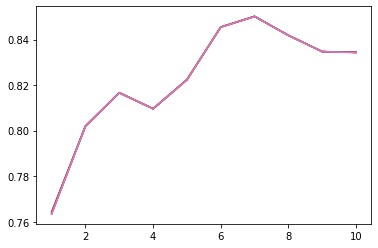

In [23]:
plt.plot(results)
plt.xlabel('Fold Number')
plt.ylabel('nDCG')

**Model with the Best Variables**

In [0]:
dtree = tree.DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=6,min_samples_leaf=60  )
dtree = dtree.fit(data_after, labels.values.ravel())
dtree_predict = dtree.predict_proba(test) 

test_users=test_users.drop('id',axis=1)

# Predict the output of the tes_users
# Each users has 5 prediction sorted by highest probability first
id_idx=-1
output_idx=0
output = pd.DataFrame(columns=['id','country'])
for prediction in dtree_predict:
  prediction=prediction.argsort()[-5:][::-1]
  id_idx+=1
  countries=le_label.inverse_transform(prediction)
  print(countries)
  for x in countries:
    print(test_id[id_idx],x)
    output = output.append({'id' : test_id[id_idx] , 'country' : x } , ignore_index=True)

# Save the oputput file
output.to_csv('drive/My Drive/airbnb/output.csv',index=False)

**Model data using KNN **

In [27]:
import scipy
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import metrics

data_train, data_test = train_test_split(data_after, test_size=0.2)
y_train, y_test=train_test_split(train_labels, test_size=0.2)

clf=neighbors.KNeighborsClassifier(n_neighbors=9)
clf.fit(data_train, y_train)
y_pred = clf.predict(data_test)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


0.0027406244875969174


In [33]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[    0     0     0     0     0     0     0    99     0     0    18     0]
 [    0     0     0     0     1     0     0   249     0     0    26     0]
 [    0     0     0     0     0     0     0   179     0     0    25     0]
 [    0     0     0     0     0     0     0   398     0     0    58     0]
 [    0     0     0     1     2     1     0   844     0     0   128     0]
 [    0     0     0     0     0     0     0   415     0     0    67     0]
 [    0     0     0     0     0     0     0   504     0     0    62     1]
 [    0     0     0     2     5     2     2 22047     0     0  2902    13]
 [    0     0     0     0     0     0     0   132     0     0    20     0]
 [    0     0     0     0     0     0     0    32     0     0     6     0]
 [    0     0     0     0     4     1     2 10966     0     0  1478     4]
 [    0     0     0     0     2     0     1  1710     0     0   281     1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:

acc = []

# Calculating accuracy for K values between 1 and 10
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(data_train, y_train.values)
    pred_i = knn.predict(data_test)
    acc.append(np.mean(pred_i == y_test.values.ravel()))
    print(i)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


14


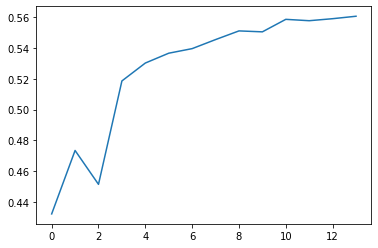

In [38]:
plt.plot(acc)